In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import HYDROPT and a default 5 component IOP model class
from hydropt.hydropt import Hydropt
from hydropt.iops import FiveCompModel, OLCI_WBANDS

In [21]:
plt.style.use('ggplot')

## Install Hydropt from git repository
Hydropt can be installed from the `dev` branch on my gitlab page using the following command:
```
$ pip install git+https://git@gitlab.com/tadzio/hydropt@6fb570fd75cd384b6cd2cd7f33fe29909245f18a
```

## IOP spectral models
I prespecified 5 component IOP model that includes CDOM, non-algal particles and pico, nano and micro phytoplankton.

#### Color dissolved organic matter
The absorption by CDOM at wavelength $\lambda$ can be modelled as follows:

$$
a_{cdom}(\lambda) = a_{cdom}(440) \exp\Big[-S(\lambda - 440)\Big]
$$
The slope $S$ varies slightly for different waters, with values ranging from 0.01 to 0.02 $nm^{-1}$ (Bricaud et al. 1981; Twardowski et al. 2004). For $S$ we assume a typical value of 0.017 $nm^{-1}$ (Babin et al. 2003a; Stomp et al. 2007a; Kirk 2011).

#### Non-algal particles
Spectral absorption coefficients and mass specific absorption for NAP (per gram SPM) are taken from Babin et al. 2003 with $a^*_{NAP}(443) = 0.041\ m^2g^{-1}$ and so the spectral variation in absorption becomes:

$$
a_{NAP}(\lambda) = 0.041\ [SPM]\ \Big[0.75 \exp(-0.0123(\lambda-443)) \Big]
$$

For NAP we derive the scatter coefficients from Babin et al. 2003 for a purely in-organic particle assemblage
$$b_{NAP}^* = 0.57 \ m^2g^{-1} $$
with $\gamma = -1$ and a 1.4% backscatter ratio we get:

$$bb_{NAP}(\lambda) = .014* 0.57\ [NAP] \ \Big(\frac{\lambda}{\lambda_0}\Big)^{-1} $$

#### Phytoplankton size classes

IOP spectral models for three phytoplankton size classes: pico's, nano's and micro's. IOP spectral models are obtained from:

Uitz et al. 2008 PSC absorption profiles (in Supplementary): https://doi.org/10.4319/lo.2008.53.2.0614

and

*Robert J.W. Brewin, Giorgio Dall’Olmo, Shubha Sathyendranath, and Nick J. Hardman-Mountford, "Particle backscattering as a function of chlorophyll and phytoplankton size structure in the open-ocean," Opt. Express 20, 17632-17652 (2012) https://doi.org/10.1364/OE.20.017632*

### Five component model in Python

This is how I create an instance of this 5 component model:

In [22]:
# create instance of 5 comp. IOP model
iop_model = FiveCompModel()

Lets plot the SIOPs for these 5 components.

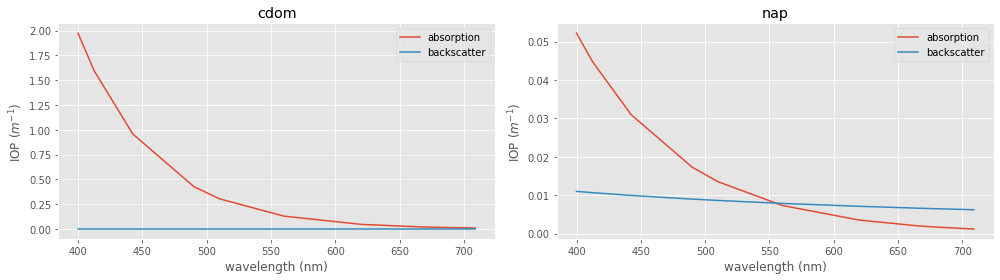

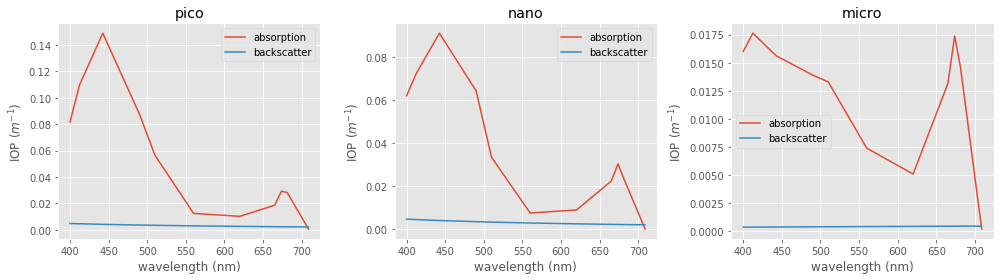

In [23]:
## units for SIOPs:
# CDOM: 1/m
# NAP: g/m3
# pico/nano/micro: mg/m3

# now lets plot IOPs per unit absorption/concentration
iop_model.plot(cdom=1, nap=1)
iop_model.plot(pico=1, nano=1, micro=1)

To retrieve the IOPs from our model we can do:

In [24]:
# example: get absorption and backscatter for nano's at 2 g/m3
iop_model.get_iop(nano=2)

array([[[0.1238    , 0.1444    , 0.1818    , 0.1284    , 0.0668    ,
         0.0152    , 0.018     , 0.0448    , 0.06065   , 0.047025  ,
         0.000375  ],
        [0.00952504, 0.00912341, 0.00826936, 0.00716929, 0.00677879,
         0.00594686, 0.00515706, 0.0046752 , 0.00459042, 0.00451982,
         0.00427622]]])

The first array is absorption at OLCI wavebands and second row are the backscatter coeffients.

In [25]:
plt.plot(OLCI_WBANDS, iop_model.get_iop(nano=2)[0].T)

In [26]:
# or multiple IOPs at a time
iop_model.get_iop(pico=1, nano=1, micro=1)

array([[[0.0816    , 0.109875  , 0.148875  , 0.0875    , 0.0565    ,
         0.0124    , 0.0102    , 0.0186    , 0.0292    , 0.0282375 ,
         0.0005875 ],
        [0.00476252, 0.0045617 , 0.00413468, 0.00358464, 0.0033894 ,
         0.00297343, 0.00257853, 0.0023376 , 0.00229521, 0.00225991,
         0.00213811]],

       [[0.0619    , 0.0722    , 0.0909    , 0.0642    , 0.0334    ,
         0.0076    , 0.009     , 0.0224    , 0.030325  , 0.0235125 ,
         0.0001875 ],
        [0.00476252, 0.0045617 , 0.00413468, 0.00358464, 0.0033894 ,
         0.00297343, 0.00257853, 0.0023376 , 0.00229521, 0.00225991,
         0.00213811]],

       [[0.016     , 0.017625  , 0.015625  , 0.0139    , 0.0133    ,
         0.0074    , 0.0051    , 0.01315   , 0.017375  , 0.014625  ,
         0.0002125 ],
        [0.00037501, 0.00037966, 0.00039047, 0.00040672, 0.00041328,
         0.00042904, 0.00044687, 0.00045957, 0.00046198, 0.00046403,
         0.00047143]]])

## Hydropt forward model
Now we can use the Hydropt forward model and the 5 component IOP model to calculate $R_{rs}$ (for now at NADIR, sun angle at 30 deg):

In [30]:
# initialize Hydropt instance w. our 5 comp model
hydropt = Hydropt(iop_model)

In [31]:
rrs_example = hydropt.forward(cdom=.005, nap=.01, pico=.01, nano=1, micro=.05)

In [32]:
plt.plot(OLCI_WBANDS, rrs_example)

However `Hydropt` was built for certain range of absorption and backscatter coefficients so caution must be taken when extrapolating beyond this range. `Hydropt` will give a warning when absorption or backscatter coefficient(s) exceed far beyond the bounds:

In [20]:
hydropt.forward(cdom=10, nap=200, pico=.01, nano=1, micro=.05)

/Users/tadzio/anaconda3/envs/hydropt-4-sent3/lib/python3.6/site-packages/hydropt/hydropt.py:74: UserWarning: IOP(s) exceed bounds of polynomial model.
            Caution must be taken when extrapolating outside of bounds
  Caution must be taken when extrapolating outside of bounds''')


array([0.0030182 , 0.00362715, 0.00566935, 0.01190785, 0.01686018,
       0.03209297, 0.04080626, 0.05370222, 0.0561085 , 0.05764893,
       0.05562561])

#### Simulating reflectance spectra
We use the model of Brewin et al. (2010) to determine the relative contribution of the three different phytoplankton size classes to total chlorophyll-a. The model was used with estimated parameters below the first optical depth ($\tau$<0.6, see table 2 Brewin et al. 2010):


$C = C_1 + C_2 +C_3$

$C_{1} = C_{1}^m[1-exp(-S_{1}C)]$

$C_{1,2} = C_{1,2}^m[1-exp(-S_{1,2}C)]$

$C_3 = C - C_{1,2}$

where $C$ is the total chlorophyll-a concentration and $C_1$, $C_2$, $C_3$ are the concentrations of pico,nano and microplankton resp. and parameters:

|Range $\tau$| Mean $\tau$ | $C_{1,2}^m$ | $S_{1,2}$ | $C_1^m$ | $S_1$ | $C$ range     |
| ---------- | ----------- | ----------- | --------- | ------- | ----- | ------------- |
| 0.0 - 0.6  | 0.388       | 1.001       | 0.931     | 0.098   | 8.271 | 0.022 - 5.643 |

In [33]:
# lets define the model
def psc_concentration(chl):
    #constants
    cm_pico_nano = 1.001
    s_pico_nano = 0.931
    cm_pico = 0.098
    s_pico = 8.271
    # calculate pico concentrations
    c_pico = cm_pico*(1-np.exp(-s_pico*chl))
    # calculate pico+nano concentrations
    c_pico_nano = cm_pico_nano*(1-np.exp(-s_pico_nano*chl))
    # calculate nano
    c_nano = c_pico_nano - c_pico
    # calculate micro 
    c_micro = chl - c_pico_nano
    
    return c_pico, c_nano, c_micro

This is how it looks like:

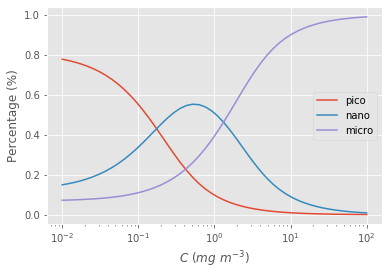

In [34]:
# log-space for Chl concentrations
chl = np.logspace(-2,2)

plt.plot(chl, psc_concentration(chl)[0]/chl, label='pico')
plt.plot(chl, psc_concentration(chl)[1]/chl, label='nano')
plt.plot(chl, psc_concentration(chl)[2]/chl, label='micro')
plt.xscale('log')
plt.xlabel('$C\ (mg\ m^{-3})$')
plt.ylabel('Percentage (%)')
plt.legend()

In [37]:
plt.plot(chl, psc_concentration(chl)[0], label='pico')
plt.plot(chl, psc_concentration(chl)[1], label='nano')
plt.plot(chl, psc_concentration(chl)[2], label='micro')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$C\ (mg\ m^{-3})$')
plt.ylabel('Chlorophyll per size class ($mg\ m^{-3}$)')
plt.legend()

Notice how pico and nano level off at 0.1 and 1 $mg\ m^{-3}$. Now we can use Brewin's model and Hydropt to make forward simulations for changes in phytoplankton size class structure:

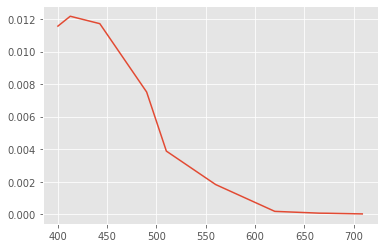

In [47]:
# lets assume case-I
chl = .01
pico, nano, micro = psc_concentration(chl)
cdom = .01
nap = .01
# calculate rrs
rrs_c1 = hydropt.forward(cdom=cdom, nap=nap, pico=pico, nano=nano, micro=micro)
plt.plot(OLCI_WBANDS, rrs_c1)

Now another example for case-II

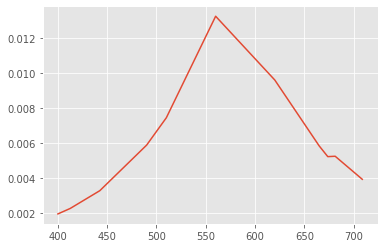

In [46]:
# lets assume case-II
chl = 10
pico, nano, micro = psc_concentration(chl)
cdom = 1
nap = 10
# calculate rrs
rrs_c2 = hydropt.forward(cdom=cdom, nap=nap, pico=pico, nano=nano, micro=micro)
plt.plot(OLCI_WBANDS, rrs_c2)